# Comparing Nemotron Models

Comparing **nemotron-3-nano-30b-a3b** vs **nemotron-nano-9b-v2** on Open Telco benchmarks.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/gsma/open_telco/blob/main/notebooks/2-comparing-models.ipynb)

This is a simple notebook explaining how to evaluate two models **nemotron-3-nano-30b-a3b** vs **nemotron-nano-9b-v2** Telelogs, TeleMath, TeleQnA and 3GPP_TSG. We will use Inspect AI to convert the results into a .parquet file, to furthermore plot the comparative results in a bar chart.

## Installation

Let's ensure we install uv and execute the dependencies using uv sync through the pyproject.toml file.



In [1]:
%%capture
import os

# Install uv package manager
!curl -LsSf https://astral.sh/uv/install.sh | sh

# Navigate to repo root (notebook is in notebooks/ folder)
os.chdir(
    os.path.dirname(os.getcwd())
    if os.path.basename(os.getcwd()) == "notebooks"
    else os.getcwd()
)

# Install dependencies
!~/.local/bin/uv python pin 3.11
!~/.local/bin/uv sync
!~/.local/bin/uv pip install inspect-viz matplotlib

## API Key Setup

Set your API keys below. In Google Colab, you can use Secrets (key icon in left sidebar) to store `OPENROUTER_API_KEY` and `HF_TOKEN` securely.

In [ ]:
import os

# Try to load from Colab secrets first, then fall back to .env
try:
    from google.colab import userdata

    os.environ["OPENROUTER_API_KEY"] = userdata.get("OPENROUTER_API_KEY")
    os.environ["HF_TOKEN"] = userdata.get("HF_TOKEN")
    print("Loaded API keys from Colab secrets")
except Exception:
    from dotenv import load_dotenv

    load_dotenv()
    print("Loaded API keys from .env file")

assert os.getenv("OPENROUTER_API_KEY"), (
    "OPENROUTER_API_KEY not set. Add it to Colab secrets or .env file."
)

## Using eval_set

`eval_set` runs multiple evaluations across multiple models. Models run in parallel.

| Parameter | Description |
|-----------|-------------|
| `tasks` | List of evaluation files |
| `model` | List of models (runs in parallel) |
| `log_dir` | Directory for logs |
| `limit` | Samples to run (for testing) |
| `epochs` | Iterations per sample |

Normally, we suggest to run these evaluations directly in the console, but for education purposes we'll use `uv run` in the code below.

In [6]:
MODELS = (
    "openrouter/nvidia/nemotron-3-nano-30b-a3b,openrouter/nvidia/nemotron-nano-9b-v2"
)
LIMIT = 5

!~/.local/bin/uv run inspect eval \
    src/open_telco/teleqna/teleqna.py \
    src/open_telco/telemath/telemath.py \
    src/open_telco/telelogs/telelogs.py \
    src/open_telco/three_gpp/three_gpp.py \
    --model {MODELS} \
    --limit {LIMIT} \
    --log-dir logs/nemotron-comparison

[>1u[?2026$p[?2048$p                                                                                
  Tasks   Running Samples   Console                                             
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
     

## View Results

Each evaluation will create a .eval file containing the LLM traces and scores. These will be saved in /logs, inside the folder. To prepare the dataset, it's neccesary to use ``uv run inspect view`` and run a localhost server to view the results.
Therefore, we will use ``subprocess.Popen`` to run the server and continue to the next cell, otherwise, our notebook will freeze.

In [7]:
import os
import subprocess
import time

# Start inspect view in background
process = subprocess.Popen(
    [
        os.path.expanduser("~/.local/bin/uv"),
        "run",
        "inspect",
        "view",
        "start",
        "--log-dir",
        "logs/nemotron-comparison",
    ],
    stdout=subprocess.PIPE,
    stderr=subprocess.STDOUT,
    text=True,
)

time.sleep(3)
INSPECT_VIEW_URL = "http://127.0.0.1:7575"
print(f"Inspect viewer running at: {INSPECT_VIEW_URL}")

Inspect viewer running at: http://127.0.0.1:7575


## Analysing Models

### Data Preparation

- Reading logs into a data frame with `evals_df()`
- Using the `prepare()` function to add `model_info()` and `log_viewer()` columns to the data frame
- You can additionally use the `task_info()` operation to map lower-level task names to task display names (e.g. "teleqna" -> "TeleQnA", "three_gpp" -> "3GPP TSG")

Note that both the log viewer links and model names are optional (the plot will render without links and use raw model strings if the data isn't prepared with `log_viewer()` and `model_info()`).

In [15]:
from inspect_ai.analysis import evals_df, log_viewer, model_info, prepare

df = evals_df("logs/nemotron-comparison")
df = prepare(df, [model_info(), log_viewer("eval", {"logs": "http://127.0.0.1:7575"})])
df.to_parquet("evals.parquet")
print("Saved evals.parquet")

Saved evals.parquet


### B

The `scores_by_task()` function renders a bar plot for comparing eval scores.

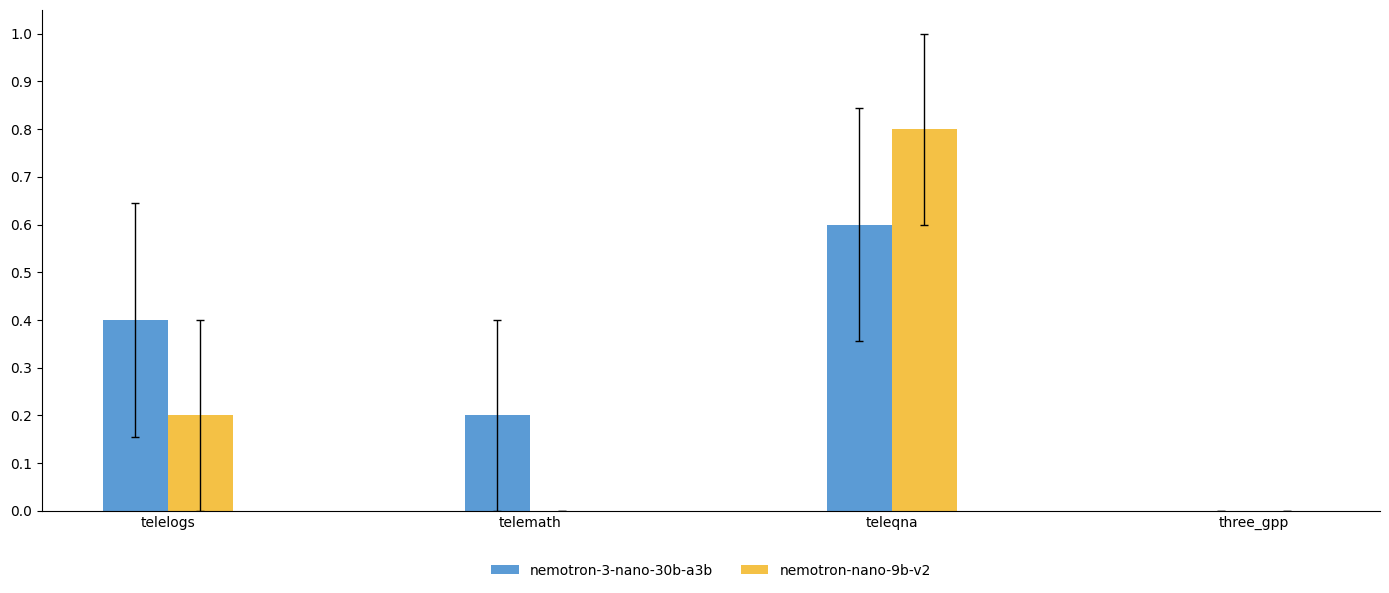

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Load data from parquet
df = pd.read_parquet("evals.parquet")
df["score_headline_value"] = df["score_headline_value"].fillna(0)
df["score_headline_stderr"] = df["score_headline_stderr"].fillna(0)

# Get benchmarks and models from data
benchmarks = sorted(df["task_name"].unique())
models_full = sorted(df["model_display_name"].unique())
models = [m.replace("openrouter/nvidia/", "") for m in models_full]

# Build scores and errors dicts from parquet
scores = {}
errors = {}
for model_full, model_short in zip(models_full, models):
    scores[model_short] = []
    errors[model_short] = []
    for task in benchmarks:
        row = df[(df["task_name"] == task) & (df["model_display_name"] == model_full)]
        if len(row) > 0:
            scores[model_short].append(float(row["score_headline_value"].values[0]))
            errors[model_short].append(float(row["score_headline_stderr"].values[0]))
        else:
            scores[model_short].append(0.0)
            errors[model_short].append(0.0)

# Colors for each model
colors = {
    "nemotron-3-nano-30b-a3b": "#5B9BD5",
    "nemotron-nano-9b-v2": "#F4C145",
}

# Plot setup
x = np.arange(len(benchmarks))
width = 0.18
fig, ax = plt.subplots(figsize=(14, 6))

# Draw bars
for i, model in enumerate(models):
    offset = (i - 0.5) * width
    ax.bar(
        x + offset,
        scores[model],
        width,
        label=model,
        color=colors[model],
        yerr=errors[model],
        capsize=3,
        error_kw={"elinewidth": 1, "capthick": 1, "ecolor": "black"},
    )

# Formatting
ax.set_xticks(x)
ax.set_xticklabels(benchmarks)
ax.set_ylim(0, 1.05)
ax.set_yticks(np.arange(0, 1.1, 0.1))
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f"{y:.1f}"))
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.tick_params(axis="x", length=0)
ax.legend(
    loc="upper center", bbox_to_anchor=(0.5, -0.08), ncol=len(models), frameon=False
)

plt.tight_layout()
plt.savefig("scores_by_task.png", dpi=150, bbox_inches="tight")
plt.show()